# For Training and Loading the Pretrained Model on a Fresh Dataset

In [44]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from keras.layers import Input
import tensorflow as tf
import tensorflow_hub as hub
# import tf.keras.callbacks 

In [45]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.9.2
Hub version: 0.12.0
GPU available


In [46]:
df_e=pd.read_csv("efficient-net-logger.csv")
df_e.head()

,epoch,accuracy,loss
0,0,0.503875,1.626086
1,1,0.577375,1.384375
2,2,0.600187,1.310445
3,3,0.617562,1.263306
4,4,0.627437,1.228566


In [47]:
df_m=pd.read_csv("mobile-net-logger.csv")
df_m.head()

,epoch,accuracy,loss
0,0,0.508500,1.617241
1,1,0.583375,1.352320
2,2,0.605937,1.277720
3,3,0.619812,1.231731
4,4,0.630625,1.198407


In [48]:
df_v=pd.read_csv("vision-trans-logger.csv")
df_v.head()

,epoch,accuracy,loss
0,0,0.526500,2.873757
1,1,0.641625,2.070771
2,2,0.683000,1.864125
3,3,0.706438,1.846899
4,4,0.738750,1.688732


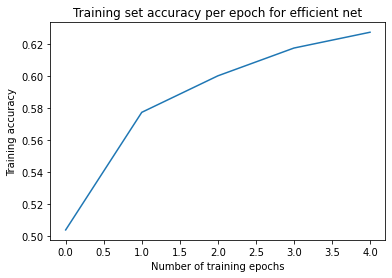

In [49]:
plt.plot(df_e.epoch, df_e.accuracy)
# plt.plot(df_v.epoch, df_v.loss)
plt.xlabel("Number of training epochs")
plt.ylabel("Training accuracy")
# plt.ylabel("Training loss")
# plt.title("Training set loss per epoch for vision transformers")
plt.title("Training set accuracy per epoch for efficient net")
plt.savefig('efficient_net_a.png')

In [107]:
# # Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
import sys

drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Datathon/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [108]:
%cd '/content/gdrive/My Drive/Datathon/'

/content/gdrive/.shortcut-targets-by-id/18Pjuiby86W8tPsgJuQAMo0AMjzsG0pLw/Datathon


In [52]:
!ls

'~'				        mobile_net_l.png
 Datathon2.ipynb		        models
 datathonindoml-2022.zip	        models_archit
 densenet_a.png			       'New Models.ipynb'
 dense-net-logger.csv		        predicted_label_3.csv
 densenet_l.png			        predicted_label.csv
 drive				       'rekhani LSTM.ipynb'
 efficient_net_a.png		        resnet_a.png
 efficient-net-logger.csv	        res-net-logger.csv
 efficient_net_l.png		        resnet_l.png
'few shot.ipynb'		        sample_submission.csv
'for RESNETS.ipynb'		        train
 full_np_array.npy		        train_labels.csv
 kaggle-indoml-submission.csv	        validation
 kaggle-indoml-submission-model-2.csv   vision_trans_a.png
 logs				       'Vision Transformers.ipynb'
 mobile_net_a.png		        vision-trans-logger.csv
 mobile-net-logger.csv		        vision_trans_l.png
 mobile-net-logger.gsheet


In [53]:
train_labels_csv = pd.read_csv("train_labels.csv")

In [54]:
labels = train_labels_csv["label"].to_numpy() # convert labels column to NumPy array (from Training Dataset)
# Finding the unique labels
unique_labels = np.unique(labels)
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_labels) for label in labels]


In [55]:
# Create pathnames from image ID's
train_path = "train/train/"
filenames = [train_path + str(fname) + ".jpeg" for fname in train_labels_csv["id"]]      # Fetching training files' IDs from train_labels_csv

val_path = "validation/validation/"
val_filenames = [val_path + str(fname) for fname in os.listdir(val_path)]       # Fetching Validation files' IDs from the validation set

In [56]:
X_test = filenames[4000:5000]
y_test = boolean_labels[4000:5000]

In [57]:
# Setup X & y variables
X = filenames[0:4000]
y = boolean_labels[0:4000]

In [58]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [90]:
# Define image size
IMG_SIZE = 256

def process_image_2(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [59]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [91]:
# Create a simple function to return a tuple (image, label)
def get_image_label_2(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image_2(image_path)
  return image, label

In [84]:
# Define the batch size, 32 is a good default
BATCH_SIZE=32
# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a training dataset, we shuffle it
  print("Creating training data batches...")
  # Turn filepaths and labels into Tensors
  data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                            tf.constant(y))) # labels
  

  # Create (image, label) tuples (this also turns the image path into a preprocessed image)
  data = data.map(get_image_label)

    # Turn the data into batches
  data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [92]:
# Define the batch size, 32 is a good default
BATCH_SIZE=32
# Create a function to turn data into batches
def create_data_batches_2(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a training dataset, we shuffle it
  print("Creating training data batches...")
  # Turn filepaths and labels into Tensors
  data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                            tf.constant(y))) # labels
  

  # Create (image, label) tuples (this also turns the image path into a preprocessed image)
  data = data.map(get_image_label_2)

    # Turn the data into batches
  data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [61]:
len(X)

4000

In [62]:
# Turn full training data in a data batch

# full_data = create_data_batches(X, y, 4000)

In [85]:
full_data_test = create_data_batches(X_test, y_test, 32)

Creating training data batches...


In [86]:
full_data_test

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.bool, name=None))>

In [93]:
full_data_test_2= create_data_batches(X_test, y_test, 32)

Creating training data batches...


In [94]:
full_data_test_2

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.bool, name=None))>

In [65]:
# for image, label in full_data.map:
#   print(image.shape, label.shape)

In [66]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels) # number of unique labels

# Setup model URL from TensorFlow Hub
# MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"
# MODEL_URL ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/classification/2"
MODEL_URL ="https://tfhub.dev/google/supcon/resnet_v1_200/imagenet/classification/1"


In [67]:
# we will build the model using the Keras API

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building the model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="softmax") # Layer 2 (output layer). Softmax will predict the probabilities for each class for each image
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # An optimizer helping our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

## Creating the Model 2 for Full data Training

In [68]:
# # # Instantiate a new model for training on the full dataset
# full_model2 = create_model()
# full_model2.summary()

In [69]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [70]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, so we monitor only training accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=4)

logger= tf.keras.callbacks.CSVLogger("few-shot-logger.csv")

In [71]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models_archit",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [72]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [73]:
# # Fit the full model to the full training data
# full_model2.fit(x=full_data,
#                epochs=5,
#                callbacks=[full_model_tensorboard, 
#                           full_model_early_stopping, logger])

In [74]:
# Save our model trained on 4000 images from the Training Dataset
# save_model(full_model2, suffix="res-net")

# x=save_model(full_model2, suffix="res-net")

In [75]:
# check train and test data size

In [76]:
# Load our model trained on 1000 images

# loaded_model = load_model('models_archit/20221112-02251668219959-res-net.h5')
# loaded_model = load_model(x)

In [77]:
# X_val = X[:500]
# y_val = y[:500]
# val_data = create_data_batches(X_val, y_val, valid_data=True)

In [83]:
full_data_test

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16,), dtype=tf.bool, name=None))>

In [109]:
!ls

'~'				        mobile_net_l.png
 Datathon2.ipynb		        models
 datathonindoml-2022.zip	        models_archit
 densenet_a.png			       'New Models.ipynb'
 dense-net-logger.csv		        predicted_label_3.csv
 densenet_l.png			        predicted_label.csv
 drive				       'rekhani LSTM.ipynb'
 efficient_net_a.png		        resnet_a.png
 efficient-net-logger.csv	        res-net-logger.csv
 efficient_net_l.png		        resnet_l.png
'few shot.ipynb'		        sample_submission.csv
'for RESNETS.ipynb'		        train
 full_np_array.npy		        train_labels.csv
 kaggle-indoml-submission.csv	        validation
 kaggle-indoml-submission-model-2.csv   vision_trans_a.png
 logs				       'Vision Transformers.ipynb'
 mobile_net_a.png		        vision-trans-logger.csv
 mobile-net-logger.csv		        vision_trans_l.png
 mobile-net-logger.gsheet


In [112]:
# # Evaluate the loaded model for all models

# resnet_archit
loaded_model = load_model('models_archit/20221112-15151668266108-res-net.h5')
loaded_model.evaluate(full_data_test)

# dense
loaded_model = load_model('models_archit/20221112-09411668246088-dense-net.h5')
loaded_model.evaluate(full_data_test)

# mobile
loaded_model = load_model('models_archit/20221112-00031668211416-mobile-net.h5')
loaded_model.evaluate(full_data_test)

# mobile_raj
loaded_model = load_model('models/20221007-04581665118720-initial-4000-images-Adam.h5')
loaded_model.evaluate(full_data_test)

# mobile_raj_again
loaded_model = load_model('models/20221007-08281665131319-full-trained-adam.h5')
loaded_model.evaluate(full_data_test)

# mobile_raj_again_again
loaded_model = load_model('models/20221008-14551665240924-full-model-2-Adam.h5')
loaded_model.evaluate(full_data_test)
predictions = loaded_model.predict(full_data_test, verbose=1) 
predictions=pd.DataFrame(predictions)
predictions.to_csv('final_submit_approx_predicted_label_mobile-net-full.csv')

# efficient
loaded_model = load_model('models_archit/20221112-02251668219959-efficient-net.h5')
loaded_model.evaluate(full_data_test)
predictions = loaded_model.predict(full_data_test, verbose=1) 
predictions=pd.DataFrame(predictions)
predictions.to_csv('final_submit_approx_predicted_label_efficient-net.csv')


Loading saved model from: models_archit/20221112-15151668266108-res-net.h5
32/32 [==============================] - 15s 341ms/step - loss: 1.7276 - accuracy: 0.4530
Loading saved model from: models_archit/20221112-09411668246088-dense-net.h5
32/32 [==============================] - 8s 230ms/step - loss: 4.5251 - accuracy: 0.2220
Loading saved model from: models_archit/20221112-00031668211416-mobile-net.h5
32/32 [==============================] - 10s 284ms/step - loss: 1.2096 - accuracy: 0.6310
Loading saved model from: models/20221007-04581665118720-initial-4000-images-Adam.h5
32/32 [==============================] - 8s 230ms/step - loss: 1.5378 - accuracy: 0.5470
Loading saved model from: models/20221007-08281665131319-full-trained-adam.h5
32/32 [==============================] - 7s 216ms/step - loss: 0.9350 - accuracy: 0.7040
Loading saved model from: models/20221008-14551665240924-full-model-2-Adam.h5
32/32 [==============================] - 7s 214ms/step
Loading saved model from: m

In [113]:
# trans
loaded_model = load_model('models_archit/20221112-20131668284006-vision-trans.h5')
loaded_model.evaluate(full_data_test_2)

predictions = loaded_model.predict(full_data_test_2, verbose=1) 
predictions=pd.DataFrame(predictions)
predictions.to_csv('final_submit_approx_predicted_label_vision_trans.csv')

Loading saved model from: models_archit/20221112-20131668284006-vision-trans.h5
32/32 [==============================] - 9s 239ms/step


In [122]:

p1=pd.read_csv('final_submit_approx_predicted_label_efficient-net.csv').drop(['Unnamed: 0'],axis=1)
p2=pd.read_csv('final_submit_approx_predicted_label_mobile-net-full.csv').drop(['Unnamed: 0'],axis=1)
p3=pd.read_csv('final_submit_approx_predicted_label_vision_trans.csv').drop(['Unnamed: 0'],axis=1)


In [124]:
p_loss=p1*0.6060+p2*0.7200+p3*0.7520/(0.6060+0.7200+0.7520)
p_acc=(p1*(1/1.2357)+p2*(1/0.8910)+p3*(1/1.5112))/((1/1.2357)+(1/0.8910)+(1/1.5112))

In [127]:
p_loss
p_loss.to_csv('ensemble_loss.csv')

In [ ]:
loss=tf.keras.losses.CategoricalCrossentropy()

In [128]:
p_acc
p_acc.to_csv('ensemble_accuracy.csv')

In [ ]:
# predictions = loaded_model.predict(val_data, verbose=1) 

In [ ]:
# predictions.shape

In [ ]:
# predictions = loaded_model.predict(val_data, verbose=1) 
# predictions=pd.DataFrame(predictions)
# predictions.to_csv('drive/MyDrive/Datathon/approx_predicted_label_res-net.csv')

In [ ]:
# # Turn prediction probabilities into their labels (Document Types)
# def get_pred_label(prediction_probabilities):
#   """
#   Turns an array of prediction probabilities into a label.
#   """
#   return unique_labels[np.argmax(prediction_probabilities)]


In [ ]:
# model_path = "models_archit/20221112-00031668211416-efficient-net.h5" 
# data_path = "validation/validation"

In [ ]:
# # Function to test the validation data stored in 'data_path' with the model stored in 'model_path'
# # here, model_path = "drive/MyDrive/Datathon/models/20221007-08281665131319-full-trained-adam.h5" 
# #       data_path = "drive/MyDrive/Datathon/validation/validation"

# def test(model_path, data_path):
#   # Load the fully trained model
#   loaded_full_model = load_model(model_path)

#   # Load validation image filenames
#   val_path = data_path
#   val_filenames = [val_path + fname for fname in os.listdir(val_path)]

#   # Getting the list of validation set IDs
#   val_id = [id for id in os.listdir(val_path)]
#   val_ids = []
#   for item in val_id:
#     val_ids.append(int(item.split(".")[0]))
  
#   # Create validation data batch so as to turn it into tensors and then fit it in our model
#   val_data = create_data_batches(val_filenames, test_data=True) 

#   # Make predictions on the validation data 
#   predictions = loaded_full_model.predict(val_data, verbose=1) 
  
#   # Getting the predicted labels in array val_pred_labels[]
#   val_pred_labels = []
#   for i in range(len(val_ids)):
#     val_pred_labels.append(get_pred_label(predictions[i]))
  
#   # Fitting the data into Pandas dataframe
#   data = []
#   for i in range(len(val_ids)):
#     data.append((val_ids[i], val_pred_labels[i]))
#   df = pd.DataFrame(data, columns=['id','label'])

#   # Saving the predicted labels on validation set images in CSV
#   # Saving the predictions to predicted_label.csv file and saving it inside the datathon folder in GDrive
#   # df.to_csv(r'drive/MyDrive/Datathon/predicted_label2.csv', index=False)

#   df.to_csv(r'predicted_label_mobile-net.csv', index=False)  
#   # df.to_csv(r'predicted_label_efficient-net.csv', index=False)  

In [ ]:
# test(model_path, data_path)

In [ ]:
# data= pd.read_csv('drive/MyDrive/Datathon/predicted_label.csv')
# data

# Few Shot Image Classification

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds

In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 500
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 16

In [ ]:
# # class Dataset:
# #     # This class will facilitate the creation of a few-shot dataset
# #     # from the Omniglot dataset that can be sampled from quickly while also
# #     # allowing to create new labels at the same time.
# #     def __init__(self, training):
# #         # Download the tfrecord files containing the omniglot data and convert to a
# #         # dataset.
# #         split = "train" if training else "test"
# #         ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
# #         # Iterate over the dataset to get each individual image and its class,
# #         # and put that data into a dictionary.
# #         self.data = {}

# #         def extraction(image, label):
# #             # This function will shrink the Omniglot images to the desired size,
# #             # scale pixel values and convert the RGB image to grayscale
# #             image = tf.image.convert_image_dtype(image, tf.float32)
# #             # image = tf.image.rgb_to_grayscale(image)
# #             image = tf.image.resize(image, [224, 224, 3])
# #             return image, label

# #         for image, label in ds.map(extraction):
# #             image = image.numpy()
# #             label = str(label.numpy())
# #             if label not in self.data:
# #                 self.data[label] = []
# #             self.data[label].append(image)
# #         self.labels = list(self.data.keys())

# def get_mini_dataset(, batch_size, repetitions, shots, num_classes, split=False):
#   temp_labels = np.zeros(shape=(num_classes * shots))
#   temp_images = np.zeros(shape=(num_classes * shots, 224, 224, 3))

#   # Get a random subset of labels from the entire label set.
#   label_subset = random.choices(self.labels, k=num_classes)
#   for class_idx, class_obj in enumerate(label_subset):
#     # Use enumerated index value as a temporary label for mini-batch in
#     # few shot learning.
#     temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
#     # If creating a split dataset for testing, select an extra sample from each
#     # label to create the test dataset.
#     # For each index in the randomly selected label_subset, sample the
#     # necessary number of images.
#     temp_images[
#         class_idx * shots : (class_idx + 1) * shots
#     ] = random.choices(self.data[label_subset[class_idx]], k=shots)

#   dataset = tf.data.Dataset.from_tensor_slices(
#     (temp_images.astype(np.float32), temp_labels.astype(np.int32))
#   )
#   dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
#   return dataset


In [ ]:
full_data

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16,), dtype=tf.bool, name=None))>

In [ ]:
ds = tfds.load("omniglot")
ds['train']

<PrefetchDataset element_spec={'alphabet': TensorSpec(shape=(), dtype=tf.int64, name=None), 'alphabet_char_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image': TensorSpec(shape=(105, 105, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        # ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        ds=full_data
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}
        for i in range(0,16):
                self.data[i]=[]

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            # image = tf.image.convert_image_dtype(image, tf.float32)
            # image = tf.image.resize(image, [224, 224, 3])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = label.numpy()
            # print(label.shape)
            for i in range(0,16):
              if label[i]==1:
                label_z=i
            self.data[label_z].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots, 16))
        temp_images = np.zeros(shape=(num_classes * shots, 224, 224, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes, 16))
            test_images = np.zeros(shape=(num_classes, 224, 224, 3))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            class_idx_vec = np.zeros(shape=(16))
            class_idx_vec[class_idx]=1
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx_vec
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx_vec
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
# test_dataset = Dataset(training=False)

In [ ]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(224, 224, 3))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(16, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 batch_normalization_4 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 112, 112, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 batch_normalization_5 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                           

In [ ]:
training = []
testing = []

# meta_iters=5
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    # print(mini_dataset)
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            labels=tf.reshape(labels, preds.shape)
            # loss = keras.losses.categorical_crossentropy(tf.reshape(labels, [25,16]), tf.reshape(preds, [25,16]))
            loss = keras.losses.categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
        # print(f"difference = {new_vars[var] - old_vars[var]}")
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        # for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
        train_set = train_dataset.get_mini_dataset(
            eval_batch_size, eval_iters, shots, classes, split=False
        )
        old_vars = model.get_weights()
        # Train on the samples and get the resulting accuracies.
        # print(train_set)
        for images, labels in train_set:
            with tf.GradientTape() as tape:
                preds = model(images)
                loss = keras.losses.categorical_crossentropy(labels, preds)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # train_preds = model.predict(images)
        # train_preds = tf.argmax(preds).numpy()
        # print(labels.shape)
        # print(preds.shape)
        num_correct=0
        for x in range(labels.shape[0]):
          for y in range(labels.shape[1]):
            demo=0
            if preds[x][y] > 0.5:
              demo=1
            if(labels[x][y]==demo):
              num_correct+=1
        acc=num_correct/80
        # num_correct = (train_preds == labels).sum()
        # Reset the weights after getting the evaluation accuracies.
        model.set_weights(old_vars)
        accuracies.append(acc)
        # training.append(accuracies[0])
        if meta_iter % 10 == 0:
            print(
                f"batch {meta_iter}: train=%{100*acc}"
            )

batch 0: train=%93.75


KeyboardInterrupt: ignored

In [ ]:
full_data_test = create_data_batches(X_test, y_test, 1000)

Creating training data batches...


In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        # ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        ds=full_data_test
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}
        for i in range(0,16):
                self.data[i]=[]

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            # image = tf.image.convert_image_dtype(image, tf.float32)
            # image = tf.image.resize(image, [224, 224, 3])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = label.numpy()
            # print(label.shape)
            for i in range(0,16):
              if label[i]==1:
                label_z=i
            self.data[label_z].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots, 16))
        temp_images = np.zeros(shape=(num_classes * shots, 224, 224, 3))
        if split:
            test_labels = np.zeros(shape=(num_classes, 16))
            test_images = np.zeros(shape=(num_classes, 224, 224, 3))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            class_idx_vec = np.zeros(shape=(16))
            class_idx_vec[class_idx]=1
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx_vec
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx_vec
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
test_dataset = Dataset(training=True)
# test_dataset = Dataset(training=False)

In [ ]:
if meta_iter % eval_interval == 0:
        accuracies = []
        # for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
        test_set = test_dataset.get_mini_dataset(
            eval_batch_size, eval_iters, shots, classes, split=False
        )
        old_vars = model.get_weights()
        # Train on the samples and get the resulting accuracies.
        # print(train_set)
        for images, labels in test_set:
            with tf.GradientTape() as tape:
                preds = model(images)
                loss = keras.losses.categorical_crossentropy(labels, preds)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # train_preds = model.predict(images)
        # train_preds = tf.argmax(preds).numpy()
        # print(labels.shape)
        # print(preds.shape)
        num_correct=0
        for x in range(labels.shape[0]):
          for y in range(labels.shape[1]):
            demo=0
            if preds[x][y] > 0.5:
              demo=1
            if(labels[x][y]==demo):
              num_correct+=1
        acc=num_correct/80
        # num_correct = (train_preds == labels).sum()
        # Reset the weights after getting the evaluation accuracies.
        model.set_weights(old_vars)
        accuracies.append(acc)
        # training.append(accuracies[0])
        if meta_iter % 10 == 0:
            print(
                f"batch {meta_iter}: train=%{100*acc}"
            )